# Running MDDS on protein structures

This notebook predicts distance distributions between pairs of amino acid residues using the [molecular dynamics of dummy spin label (MDDS)](https://pubs.acs.org/doi/10.1021/jp311723a) method. The script uses the [No U-Turn Sampler](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf), rather than classical Molecular Dynamics simulations, to sample the conformational space available to the dummy atom. The sampler is implemented in [TensorFlow Probability](https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX), and most of the code uses Jax.

To run this notebook, fill out the residue information below under "Step 2", then go to Runtime -> Run all.

Currently I am in the process of adding functionality for custom PDBs.

In [1]:
#@title **Step 1:** Setup Colab environment

import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt
import numpy as np
import os
from urllib.request import urlretrieve

from google.colab import files

!git clone https://github.com/biopython/biopython.git
!pip install biopython/

import Bio.PDB

seed = np.random.randint( 1000000 )

Cloning into 'biopython'...
remote: Enumerating objects: 97428, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 97428 (delta 39), reused 27 (delta 15), pack-reused 97346
Receiving objects: 100% (97428/97428), 58.66 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (73393/73393), done.
Processing ./biopython
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for biopython: filename=biopython-1.80.dev0-cp37-cp37m-linux_x86_64.whl size=2839107 sha256=75de7804df12cb613473d278c6983014b6856c565e72e4284477c98848ed1bcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-9s20xln

In [2]:
#@title **Step 2:** Define input parameters
#@markdown PDB ID of interest (must be four digits)
pdb_id = "2LZM" #@param {type:"string"}

#@markdown Residue and chain indices (separated by a colon):
residue1 = "79:A"  #@param {type:"string"}
residue2 = "131:A" #@param {type:"string"}

def to_res_chain( reschain ):
  data = reschain.split( ":" )
  return int( data[ 0 ] ), data[ 1 ]

residue1, chain1 = to_res_chain( residue1 )
residue2, chain2 = to_res_chain( residue2 )


In [3]:
#@title **Step 3:** Define functions

def get_atoms( model, atom ):
  atoms = dict()
  for chain in model.get_chains():
    for res in chain.get_residues():
      tempatom = atom
      if res.resname == "GLY" and atom == "CB":
        tempatom = "HB"
      try:
        atoms[ ( res.get_id()[ 1 ], chain.get_id() ) ] = res[ tempatom ].get_vector().get_array()
      except:
        #problem wit glycines
        #print( f"Error reading chain { chain } residue { res }" )
        continue

  return atoms

def calc_clashes( res, chain, model, dist ):
  xyz_ca = model[ 0 ][ chain ][ res ][ "CA" ].coord
  
  clashing_atoms = []
  for atom in model.get_atoms():
    if "H" in atom.name:
      continue
    if np.linalg.norm( atom.coord - xyz_ca ) < dist:
      clashing_atoms.append( atom.coord )
  return clashing_atoms

def get_positions( x, headers, residues ):

	xyz = dict()

	for r, c in residues:
		xyz[ ( r, c ) ] = [
			x[ headers.index( f"{ r }_{ c }_x" ) ],
			x[ headers.index( f"{ r }_{ c }_y" ) ],
			x[ headers.index( f"{ r }_{ c }_z" ) ]
		]
	return xyz

def set_params( residues ):

  params = {}

  for r, c in residues:
    params[ f"{ r }_{ c }_x" ] = np.random.uniform( low=-25, high=25 )
    params[ f"{ r }_{ c }_y" ] = np.random.uniform( low=-25, high=25 )
    params[ f"{ r }_{ c }_z" ] = np.random.uniform( low=-25, high=25 )
	
  return params

@jit
def vdw( x1, x2 ):
  d = jnp.linalg.norm( x1 - x2 )
  return -0.2 * ( ( 4. / d ) ** 12. - ( 4. / d ) ** 6 )

vdw_batch = vmap( vdw, in_axes=( None, 0 ) )

@jit
def xyz_energy_clash( xyz, ca, cb, n, neighbors ):

	# Calculate distance
	cb = jnp.array( cb, dtype=jnp.float32 )
	neighbors = jnp.array( neighbors, dtype=jnp.float32 )
 
	ca = jnp.array( ca, dtype=jnp.float32 )
	xyz = jnp.array( xyz, dtype=jnp.float32 )
 
  
	e_clash = vdw_batch( xyz, neighbors ).sum()

	d = jnp.sqrt( ( ( xyz - ca ) ** 2 ).sum() )
	e_d = -0.5 * ( d - 8.0 ) ** 2

	# Calculate angle
	xyz_ca = xyz - ca
	cb_ca = cb - ca
 
	theta = jnp.dot( xyz_ca, cb_ca ) / (
		jnp.linalg.norm( xyz_ca ) * jnp.linalg.norm( cb_ca ) )
	e_theta = -1 * ( 0.9599 - theta ) ** 2 # in radians

	# Calculate dihedral N-CA-CB-ON

	xyz_cb = xyz - cb
	ca_cb = ca - cb
	n_ca = n - ca

	ca_cb_norm = ca_cb / jnp.linalg.norm( ca_cb )

	v = xyz_cb - jnp.dot( xyz_cb, ca_cb_norm ) * ca_cb_norm
	w = n_ca - jnp.dot( n_ca, ca_cb_norm ) * ca_cb_norm

	x = jnp.dot( v, w )
	y = jnp.dot( jnp.cross( ca_cb_norm, v ), w )

	phi = jnp.arctan2( y, x )

	e_phi = -1.9 * ( 1. + jnp.cos( phi - 4.1888 ) ) # in radians

	return e_clash + e_d + e_theta + e_phi

In [4]:
#@title **Step 4:** Retrieve files and convert to model

# Download PDB file
# Make sure the PDB ID is four digits long
assert len( pdb_id ) == 4
pdbfile = f'{ pdb_id }.pdb'
urlretrieve( f'http://files.rcsb.org/download/{ pdb_id }.pdb',
            pdbfile )
model = Bio.PDB.PDBParser().get_structure( "TEMP", pdbfile )



In [5]:
#@title **Step 5:** Set up parameters and fit function, run the prediction

ca = get_atoms( model, "CA" )
cb = get_atoms( model, "CB" )
n = get_atoms( model, "N" )

residues = [ ( residue1, chain1 ), ( residue2, chain2 ) ]

params = set_params( residues )

headers = list( params.keys() )
x0 = tuple( params.values() )

clash_atoms = { ( r, c ): calc_clashes( r, c, model, 10. ) for r, c in residues }

@jit
def log_likelihood_coords( *x ):
  ll = 0.

  res_pos = get_positions( x, headers, residues )

  for ( res, chain ), xyz in res_pos.items():

      ll += xyz_energy_clash(
        xyz,
        ca[ ( res, chain ) ],
        cb[ ( res, chain ) ],
        n[ ( res, chain ) ],
        clash_atoms[ ( res, chain ) ]
    )

#    ll += xyz_energy(
#        xyz,
#        ca[ ( res, chain ) ],
#        cb[ ( res, chain ) ],
#        n[ ( res, chain ) ]
#    )
  
  return ll

init_key, sample_key = random.split( random.PRNGKey( 0 ) )
kernel = tfp.mcmc.NoUTurnSampler( log_likelihood_coords, 1e-2 )

states, log_probs = tfp.mcmc.sample_chain( 10000,
      current_state=x0,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500,
      seed=init_key )

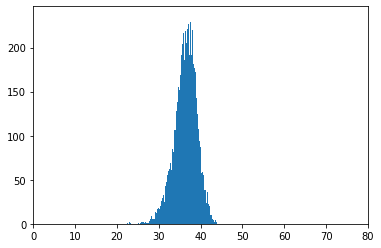

In [6]:
states = np.asarray( states )
dists = np.linalg.norm( states[ :3, : ] - states[ 3:, : ], axis=0 )
plt.hist( dists, bins=161 )
plt.xlim( 0, 80 )
plt.show()